# SC3000 Lab 1 (Monte Carlo)

Done By: Koh Yihao Kendrick (U2222663K) & Aaron Jerome Lim Li Yang (U2221616A)
<br>
Workload was equally shared between Kendrick and Aaron
<br>
This notebook showcases a thorough analysis on Monte Carlo and its application in the CartPole gym environment

## Dependencies required to run notebook

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bi

## Import statements

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import glob
import io
import base64
from collections import defaultdict
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym import logger as gymlogger
from gym.wrappers import RecordVideo

## Instantiating Gym environment

In [ ]:
env = gym.make("CartPole-v1", new_step_api=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Task 1: Development of an RL agent

## Function create_bins_and_q_table()

create_bins_and_q_table() is used to create the q table

In this lab, we utilised a bin size of 20 and limited Cart Velocty and Pole Angular Velocity to -4 to 4
This decision was primarily influenced by insights gained from a specific video, which provided valuable visual evidence and context. For further details, please refer to the following link: [1].

Since there are 4 observations, the Q-table dimensions are determined by the number of bins in each dimension of the observation space and the number of actions in the environment's action space.

In [ ]:
# Create bins and Q table
def create_bins_and_q_table():
	numBins = 20
	obsSpaceSize = len(env.observation_space.high)

	# Get the size of each bucket
	bins = [
		np.linspace(-4.8, 4.8, numBins),
		np.linspace(-4, 4, numBins),
		np.linspace(-.418, .418, numBins),
		np.linspace(-4, 4, numBins)
	]

	#Initialise empty Q-table
	qTable = np.zeros(([numBins] * obsSpaceSize + [env.action_space.n]))

	return bins, obsSpaceSize, qTable


## Function get_discrete_state()

get_discrete_state() is used to convert a continuous state representation into a discrete state index that can be used to index the Q-table.

For each dimension, the function finds the index of the bin that the state value falls into. This is done using np.digitize(state[i], bins[i]) - 1). - 1 is subtracted to convert the bin index to a zero-based index because indexing in Python starts from 0.

In [ ]:
# Given a state of the enviroment, return its descreteState index in qTable
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)

## Function training_monte_carlo()

training_monte_carlo() is used to train a Monte Carlo agent in a given environment.

### Parameters:
- `qTable`: The Q-table to be updated during training.
- `previousCnt`: A list to store the number of steps taken in each episode.
- `metrics`: A dictionary to store metrics for plotting the training progress.
- `bins`: Bins used for discretizing the continuous observation space.
- `obsSpaceSize`: The size of the observation space.

### Variables:
- `discount_rate`: The discount rate (gamma) determines the importance of future rewards.
- `num_episodes`: The number of training episodes.
- `SHOW_EVERY`: How often the current solution is rendered.
- `UPDATE_EVERY`: How often the current progress is recorded.
- `steps_per_episode`: Maximum number of steps per episode.

#### Exploration settings:
- `epsilon`: The exploration rate. Initially set to 1, it decays over time.
- `epsilon_start`: The start value for epsilon.
- `epsilon_end`: The end value for epsilon.
- `epsilon_decay_value`: Epsilon decaying rate.

### Training Process:
- For each episode:
  - Reset the environment and discretize the initial state.
  - Run the episode until termination or maximum steps:
    - Choose an action either randomly or greedily based on the current Q-table.
    - Perform the selected action in the environment.
    - If the episode terminates or reaches the maximum steps, assign a negative reward.
    - Update the episode trajectory with state-action-reward tuples.
  - Update the number of steps taken in the episode to `previousCnt`.
  - Update Q-values using the first-visit Monte Carlo method.
    - Compute G: the total discounted reward from step t with the equation,
      G for step t = Summation from k=0 to k=∞ [ gamma^k * Reward for (t+k+1) ]
    - Update the Q-table for a state-action (S,A) pair using the equation, Q(S,A) = sum of observed returns for (S,A) / number of visits to (S,A)

  - Decay epsilon if within the specified range.
  - Update metrics for plotting if the current episode is a multiple of `UPDATE_EVERY`.

In [ ]:
# Training for Monte Carlo
def training_monte_carlo(qTable, previousCnt, metrics, bins, obsSpaceSize):

	#--- VARIABLES ---

	discount_rate = 0.95
	num_episodes = 60000  # Number of iterations run
	SHOW_EVERY = 2000  # How often the current solution is rendered
	UPDATE_EVERY = 100  # How often the current progress is recorded
	steps_per_episode = 500 # Number of steps per episode

	# Exploration settings
	epsilon = 1  # not a constant, going to be decayed
	epsilon_start = 1
	epsilon_end = num_episodes // 2
	epsilon_decay_value = epsilon / (epsilon_end - epsilon_start)

	# Dictionary to store returns for each state-action pair
	returns_sum = defaultdict(float)
	returns_count = defaultdict(float)

	for episode in range(num_episodes):
		discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
		done = False  # done=True if pole falls over
		steps = 0  # Number of steps made
		episode_trajectory = []  # to store (state, action, reward) tuples for this episode

		# Generate an episode
		while not done:
			steps += 1
				# Get action from Q table with epsilon-greedy policy
			if np.random.random() > epsilon:
				action = np.argmax(qTable[discreteState])
			else:
				action = np.random.randint(0, env.action_space.n)

			newState, reward, done, truncated, _ = env.step(action)
			newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)


			 # Pole falls over or over 500 steps, assign negative reward
			if done or steps > steps_per_episode:
				reward = -375
				episode_trajectory.append((discreteState, action, reward))
				discreteState = newDiscreteState
				break

			episode_trajectory.append((discreteState, action, reward))
			discreteState = newDiscreteState

		previousCnt.append(steps)

		# Update Q-values after each episode
		visited_states_actions = set()
		for t, (state, action, reward) in enumerate(episode_trajectory):

				# Check if this state-action pair is visited for the first time in the episode
				state_action = (state, action)

				# Compute G: total discounted reward from step t
				G = sum([discount_rate ** i * step[2] for i, step in enumerate(episode_trajectory[t:])])

				if state_action not in visited_states_actions:

					# Update returns_sum and returns_count
					returns_sum[state_action] += G
					returns_count[state_action] += 1

					# Update Q-value using the first-visit Monte Carlo method
					qTable[state + (action, )] = returns_sum[state_action] / returns_count[state_action]
					visited_states_actions.add(state_action)

		# Decaying is being done every run if run number is within decaying range
		if epsilon_end >= episode >= epsilon_start:
			epsilon -= epsilon_decay_value

		# Add new metrics for graph
		if episode % UPDATE_EVERY == 0:
			latestRuns = previousCnt[-UPDATE_EVERY:]
			averageCnt = sum(latestRuns) / len(latestRuns)
			metrics['ep'].append(episode)
			metrics['avg'].append(averageCnt)
			metrics['min'].append(min(latestRuns))
			metrics['max'].append(max(latestRuns))
			print("Run:", episode, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns))

	env.close()
	return qTable, previousCnt, metrics

## Calling of training_monte_carlo() with given metrics

training_monte_carlo() prints out average, minimum and maximum per 100 runs

In [ ]:
bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # array of all scores over runs
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

# Train using Monte Carlo
qTableTrained, previousCntTrained, metricTrained = training_monte_carlo(qTable, previousCnt, metrics, bins, obsSpaceSize)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run: 0 Average: 22.0 Min: 22 Max: 22
Run: 100 Average: 22.03 Min: 9 Max: 56
Run: 200 Average: 21.89 Min: 9 Max: 68
Run: 300 Average: 22.51 Min: 8 Max: 58
Run: 400 Average: 25.0 Min: 8 Max: 91
Run: 500 Average: 21.89 Min: 9 Max: 79
Run: 600 Average: 25.03 Min: 9 Max: 121
Run: 700 Average: 23.8 Min: 9 Max: 80
Run: 800 Average: 26.16 Min: 10 Max: 99
Run: 900 Average: 24.32 Min: 9 Max: 80
Run: 1000 Average: 22.85 Min: 9 Max: 74
Run: 1100 Average: 23.06 Min: 10 Max: 102
Run: 1200 Average: 23.24 Min: 8 Max: 67
Run: 1300 Average: 26.06 Min: 9 Max: 93
Run: 1400 Average: 25.03 Min: 9 Max: 101
Run: 1500 Average: 24.2 Min: 9 Max: 82
Run: 1600 Average: 26.01 Min: 9 Max: 82
Run: 1700 Average: 23.29 Min: 10 Max: 79
Run: 1800 Average: 24.29 Min: 10 Max: 107
Run: 1900 Average: 25.48 Min: 9 Max: 81
Run: 2000 Average: 24.59 Min: 9 Max: 64
Run: 2100 Average: 25.9 Min: 8 Max: 76
Run: 2200 Average: 24.3 Min: 8 Max: 104
Run: 2300 Average: 24.11 Min: 8 Max: 96
Run: 2400 Average: 25.14 Min: 10 Max: 92
Run: 25

## Plotting of stored metrics for training

We observe a plateau average of 471.78 from run 59900-60000 which is sufficiently high as per lab requirements

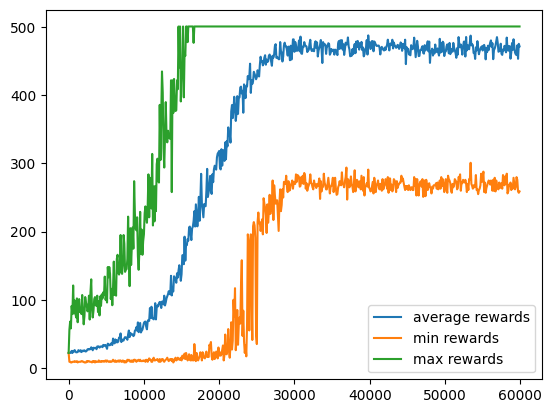

In [ ]:
# Plot graph
plt.plot(metricTrained['ep'], metricTrained['avg'], label="average rewards")
plt.plot(metricTrained['ep'], metricTrained['min'], label="min rewards")
plt.plot(metricTrained['ep'], metricTrained['max'], label="max rewards")
plt.legend(loc=4)
plt.show()

# Task 2: Demonstrate the effectiveness of the RL agent

## Function testing_monte_carlo()

testing_monte_carlo() is used to test a trained Monte Carlo agent in a given environment.

### Parameters:
- `qTable`: The trained Q-table previously returned from the training agent.
- `previousCnt`: A list to store the number of steps taken in each episode during testing.
- `metrics`: A dictionary to store metrics for plotting the testing progress.
- `bins`: Bins used for discretizing the continuous observation space.
- `obsSpaceSize`: The size of the observation space.
- `num_episodes`: The number of testing episodes (100).
- `env`: The environment used for testing.
- `envVideo`: The video rendering environment.
- `render`: A boolean flag indicating whether to render the environment during testing, used for rendering video in task 3.

### Variables:
- `step_per_episodes`: Maximum number of steps per episode during testing.
- `UPDATE_EVERY`: How often the current progress is recorded.

### Testing Process:
- For each episode in the specified number of episodes:
  - Reset the environment and discretize the initial state.
  - Run the episode until termination or maximum steps:
    - If rendering is enabled, reset and render the environment.
    - Choose actions greedily based on the learned Q-values from the Q-table.
    - Perform actions in the environment and observe the resulting state and reward.
    - If the episode terminates or reaches the maximum steps, end the episode.
  - Record the number of steps taken in the episode to `previousCnt`.
  - If rendering is disabled, record metrics such as episode number and total reward.

In [ ]:
#Test for Monte Carlo
def testing_monte_carlo(qTable, previousCnt, metrics, bins, obsSpaceSize, num_episodes, env, envVideo, render=False):
  step_per_episodes = 500
  UPDATE_EVERY = 10  # How often the current progress is recorded

  for episode in range(num_episodes):
    discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
    done = False  # has the enviroment finished?
    steps = 0  # Number of steps made

    while not done:
      if render:
        envVideo.reset()
        envVideo.render()  # if running RL comment this out
      steps += 1
      action = np.argmax(qTable[discreteState])

      newState, reward, done, truncated, _ = env.step(action)  # perform action on enviroment
      newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

			# Pole falls over or over 500 steps, end episode
      if done or steps > step_per_episodes:
        break

      discreteState = newDiscreteState

    previousCnt.append(steps)

		# Add new metrics for graph
    if not render:
      metrics['ep'].append(episode)
      metrics['reward'].append(previousCnt[episode])
      print("Reward for episode",episode,":", previousCnt[episode])
  if not render:
    averageCnt = sum(previousCnt) / len(previousCnt)
    print("Overall average:", averageCnt)


  env.close()
  return qTable, previousCnt, metrics

## Calling of testing_monte_carlo() with given metrics

testing_monte_carlo() prints out the reward per run, where num_episodes is set to 100

In [ ]:
previousCntTest = []  # array of all scores over runs
metricsTest = {'ep': [], 'reward': []}  # metrics recorded for graph

qTableTest, previousCntTest, metricTest = testing_monte_carlo(qTableTrained, previousCntTest, metricsTest, bins, obsSpaceSize, 100, env, env)

Reward for episode 0 : 501
Reward for episode 1 : 501
Reward for episode 2 : 501
Reward for episode 3 : 444
Reward for episode 4 : 501
Reward for episode 5 : 501
Reward for episode 6 : 308
Reward for episode 7 : 501
Reward for episode 8 : 501
Reward for episode 9 : 501
Reward for episode 10 : 466
Reward for episode 11 : 501
Reward for episode 12 : 501
Reward for episode 13 : 501
Reward for episode 14 : 288
Reward for episode 15 : 501
Reward for episode 16 : 393
Reward for episode 17 : 501
Reward for episode 18 : 501
Reward for episode 19 : 501
Reward for episode 20 : 501
Reward for episode 21 : 501
Reward for episode 22 : 501
Reward for episode 23 : 501
Reward for episode 24 : 331
Reward for episode 25 : 501
Reward for episode 26 : 501
Reward for episode 27 : 501
Reward for episode 28 : 501
Reward for episode 29 : 501
Reward for episode 30 : 501
Reward for episode 31 : 501
Reward for episode 32 : 297
Reward for episode 33 : 501
Reward for episode 34 : 501
Reward for episode 35 : 501
Re

## Plotting of stored metrics for testing

We observe a overall average of 475.87 which passes the lab requirements

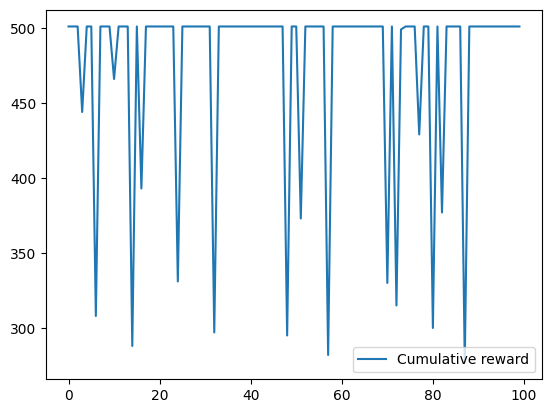

In [ ]:
# Plot graph
plt.plot(metricsTest['ep'], metricsTest['reward'], label="Cumulative reward")
plt.legend(loc=4)
plt.show()

# Task 3: Render one episode played by the developed RL agent

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Rendering video

testing_monte_carlo() is called with render flag set to true, num_episodes is set to 1 and video rendering environment as parameter inputs

In [ ]:
envVideo = RecordVideo(gym.make("CartPole-v1"), "./video")
previousCntTest = []  # array of all scores over runs
metricsTest = {'ep': [], 'reward': []}  # metrics recorded for graph

testing_monte_carlo(qTableTrained, previousCntTest, metricsTest, bins, obsSpaceSize, 1, env, envVideo, render=True)

envVideo.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is dep

# References

[1] How to Use Q-Learning to Train Gymnasium CartPole-v1 | Python Reinforcement Learning Tutorial #3. (n.d.). Www.youtube.com. Retrieved March 18, 2024, from https://youtu.be/2u1REHeHMrg?si=-0S61-s5iOlkbnxk